In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import clear_output
os.environ['KMP_DUPLICATE_LIB_OK']='True'
sns.set_theme()

# Функции создания нужной матрицы пластины и ее маски
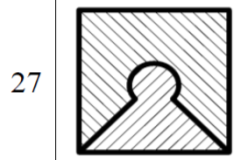
  
Она состоит из круга с центром в центре пластины и функции модуля, выходящей тоже из центра  
Пусть центр пластины имеет координаты $x_{cent}$ и $y_{cent}$ 
Таким образом функция от *i*, *j*, дающая нужную пластину будет:  
   

 

In [2]:
def built_plate(plate_size=100):
    x_center = int(plate_size / 2)
    y_center = int(plate_size / 2)
    radius = plate_size / 5
    plate = np.zeros((plate_size, plate_size))
    
    needed_dots = []
    
    for i, row in enumerate(plate):
        for j, elem in enumerate(row):
            if i <= (-abs(j - x_center) + y_center):
                plate[i, j] = 2
            elif -(i - x_center)**2 + radius**2 > 0 and  \
            j <= (np.sqrt(-(i - x_center)**2 + radius**2) + y_center) and \
            j >= (-np.sqrt(-(i - x_center)**2 + radius**2) + y_center):
                plate[i, j] = 2
            else:
                plate[i, j] = 0
                needed_dots.append([i, j])
                
    return plate, needed_dots

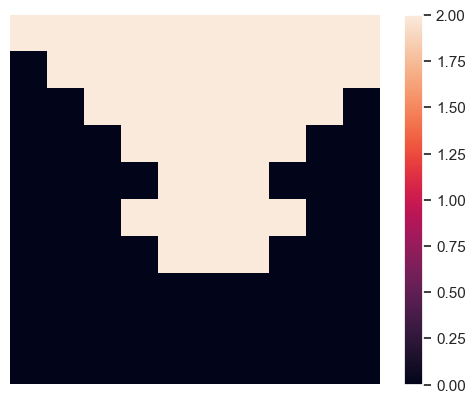

In [3]:
fig, ax = plt.subplots(1, 1)
im = ax.imshow(built_plate(10)[0])
fig.colorbar(im, ax=ax, label='')
ax.axis('off')
None

Давайте обозначим условия на разные типы данных, которые нам нужны(сформируем маску):  
1. малую часть пластины (цифрой 2)
2. граничные условия (цифра 1) 
3. те которые нужно найти (они будут 0)

In [4]:
def fill_around(matrix, dot): #Функция заполнения граничными условиями для маски
    x, y = dot[0], dot[1]    
    #upper
    if (x + 1 < matrix.shape[0] and matrix[x + 1][y] == 0):
        matrix[x + 1][y] = 1
    #left
    if (y - 1 > 0 and matrix[x][y-1] == 0):
        matrix[x][y - 1] = 1
    #right
    if (y + 1 < matrix.shape[1] and matrix[x][y + 1] == 0):
         matrix[x][y + 1] = 1

In [5]:
def build_plate_mask(size):
    mask, needed_dots = built_plate(size)
    for i, row in enumerate(mask):
        itemindex = np.where(row == 2)
        if itemindex[0].size != 0:
            first = itemindex[0][0]
            last = itemindex[-1][-1]
        else: 
            first, last = -1, -1
        #print(first, last)
        if first != -1:
            for j in range(first, last + 1, 1):
                fill_around(mask, (i, j))

        mask[-1] = 1
        if (mask[i][0]!=2):
            mask[i][0] = 1 
        if (mask[i][-1]!=2):
            mask[i][-1] = 1 
    return mask

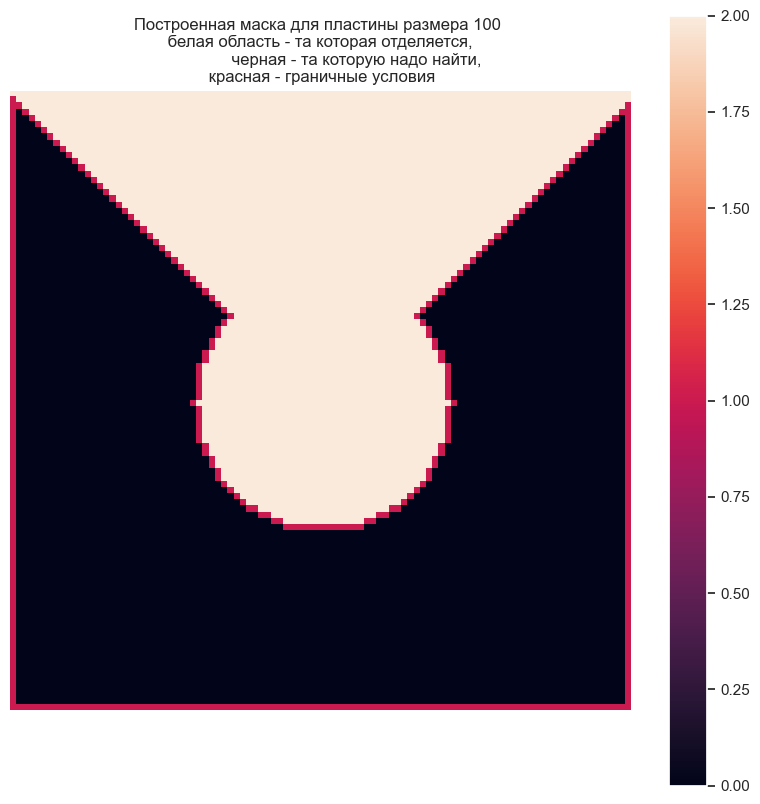

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
im = ax.imshow(build_plate_mask(100))
fig.colorbar(im, ax=ax, label='')
ax.set_title(f"Построенная маска для пластины размера {100} \n белая область - та которая отделяется, \n \
                черная - та которую надо найти, \n красная - граничные условия")
ax.axis('off')
None

# Построение вычислений
  
Для проверки будем использовать функцию $F(x, y) = sin(x)*cos(y)$  
ввиду ее несимметричности(см. рисунок ниже), откуда следует более наглядная интерпретация результатов

In [7]:
def test_func(x, y):
    return np.sin(x)*np.cos(y) + 5#-2*np.pi**2*np.sin(np.pi*x)*np.sin(np.pi*y)

Объявление нужных констант, сравнение 

In [8]:
# размер пластины в узлах
test_size = 100

# левая граница, правая граница и шаг
a = 0
b = 1
h = 1/test_size

# x, y и распределение F
x = np.arange(a, b, h)
y = np.arange(a, b, h)
F = test_func(x[:, None], y[None, :])

#точность
eps = 1e-4
#маска
mask = build_plate_mask(test_size)


print(x.shape)
print(y.shape)
print(F.shape)
print(mask.shape)

(100,)
(100,)
(100, 100)
(100, 100)


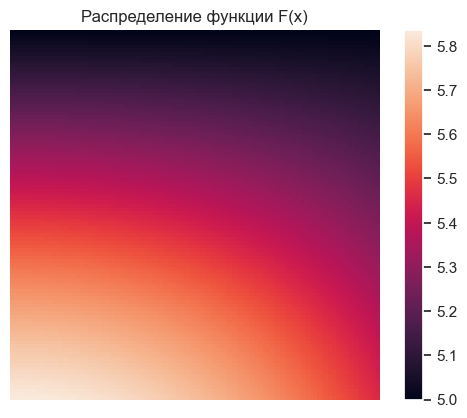

In [9]:
fig, ax = plt.subplots(1, 1)
im = ax.imshow(F)
fig.colorbar(im, ax=ax, label='')
ax.axis('off')
ax.set_title('Распределение функции F(x)')
None

In [39]:
def border_zero(x, y):
    return 0

def border_number(x, y):
    return 5

def border_sin_function(x, y):
    return np.sin(np.pi*x)*np.cos(np.pi*y)

def border_e_sin_function(x, y):
    return np.exp(x)*np.sin(np.pi*y)

In [50]:
def five_dots_jacoby_method(mask,  eps=1e-4,
                            left_border=border_zero, right_border=border_zero, 
                            upper_border=border_zero, downer_border=border_zero):
    
    U_prev = np.zeros_like(mask)
    U_next = np.zeros_like(mask)
    t = 1 / mask.shape[0]
    #conditions
    for i, row in enumerate(mask):
        for j, elem in enumerate(row):
            if elem==1:
                if j == 0:
                    U_prev[i][j] = left_border(i*t, j*t)
                    U_next[i][j] = left_border(i*t, j*t)
                elif i == mask.shape[0] - 1:
                    U_prev[i][j] = downer_border(i*t, j*t)
                    U_next[i][j] = downer_border(i*t, j*t)
                elif j == mask.shape[1] - 1:
                    U_prev[i][j] = right_border(i*t, j*t)
                    U_next[i][j] = right_border(i*t, j*t)
                else: 
                    U_prev[i][j] = upper_border(i*t, j*t)
                    U_next[i][j] = upper_border(i*t, j*t)
    
    #First step
    for i, row in enumerate(U_next):
        for j, elem in enumerate(row):
                if mask[i][j] == 0:
                    U_next[i][j] = 1/4*(U_prev[i-1][j] + U_prev[i+1][j] + U_prev[i][j-1] + U_prev[i][j+1]) - h**2/4*F[i][j]

    norm = np.linalg.norm(U_next - U_prev, ord=np.inf)       
    norm_list = []
    norm_list.append(norm)
    iterator = 0
    #Counting Loop
    while norm > eps and iterator < 100000:
        U_prev = U_next.copy()
        for i, row in enumerate(U_next):
            for j, elem in enumerate(row):
                if mask[i][j] == 0:
                    #print(i, j)
                    U_next[i][j] = 1/4*(U_prev[i-1][j] + U_prev[i+1][j] + U_prev[i][j-1] + U_prev[i][j+1]) - h**2/4*F[i][j]

        norm = np.linalg.norm(U_next - U_prev, ord=np.inf)
        norm_list.append(norm)
        iterator += 1
        if iterator % 100 == 0:
            print(f"{iterator} шаг, норма = {norm}" )
        
    return U_next, norm_list

In [66]:
U_next, norms = five_dots_jacoby_method(mask, eps, border_zero, border_zero, border_zero, border_zero)
clear_output()

# Анализ полученных результатов

### График норм

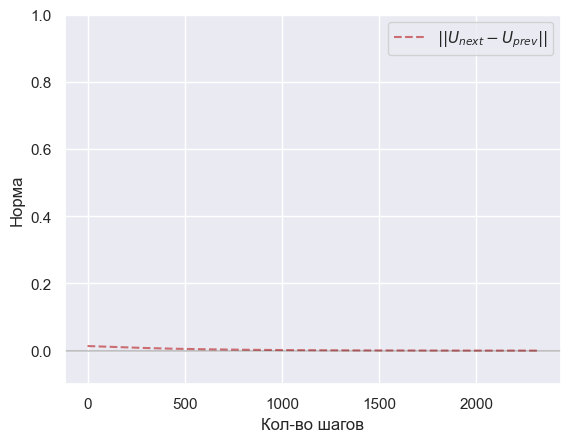

In [67]:
fig, ax = plt.subplots(1, 1)
im = ax.plot(norms, alpha=0.8, label="$||U_{next} - U_{prev}||$", c='r', ls='--')
ax.set_xlabel('Кол-во шагов')
ax.set_ylabel('Норма')
ax.set_ylim(-0.1, 1)
ax.axhline(0, alpha=0.1, c='black')
ax.axhline(0, alpha=0.1, c='black')
ax.legend()

## Тепловая карта пластины в двумерном пространстве

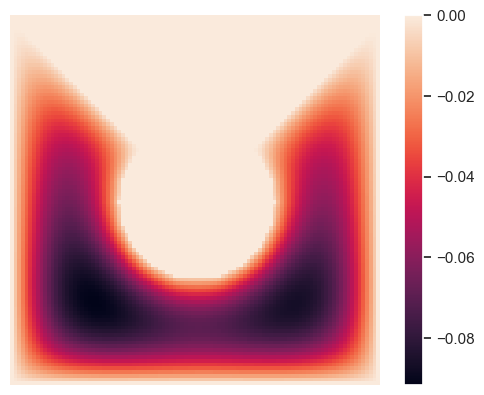

In [68]:
fig, ax = plt.subplots(1, 1)
im = ax.imshow(U_next)
fig.colorbar(im, ax=ax, label='')
ax.axis('off')
None

## Графики в трехмерном пространстве

In [69]:
import matplotlib
X, Y = np.meshgrid(x, y)

### Вид сбоку (если смотреть на двумерный график - слева направо)

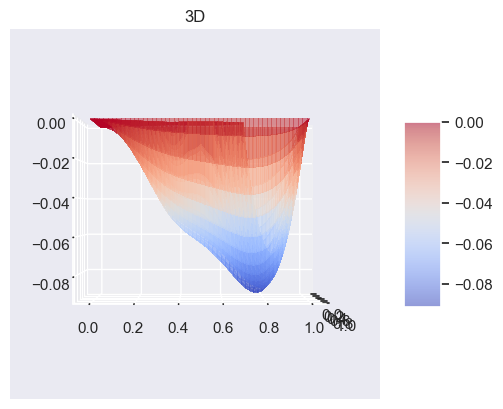

In [70]:
fig = plt.figure()
ax = plt.axes(projection='3d')
im = ax.plot_surface(X, Y, U_next, alpha=0.5, cmap=matplotlib.cm.coolwarm,
                       linewidth=0, antialiased=False)
fig.colorbar(im, shrink=0.5, aspect=5)
ax.set_title('3D');
ax.view_init(0, 0)

### Вид спереди (если смотреть на двумерный график - снизу наверх)

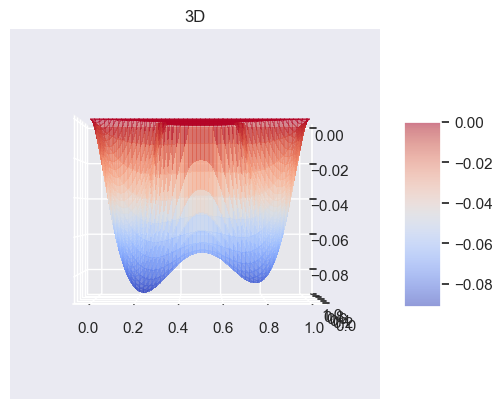

In [71]:
fig = plt.figure()
ax = plt.axes(projection='3d')
im = ax.plot_surface(X, Y, U_next, alpha=0.5, cmap=matplotlib.cm.coolwarm,
                       linewidth=0, antialiased=False)
fig.colorbar(im, shrink=0.5, aspect=5)
ax.set_title('3D');
ax.view_init(0, 270)

***Видим, что левый экстремум функции явно меньше, что следует из вида функции $F(x, y)$***

### Поворот трехмерной картинки со всех сторон 

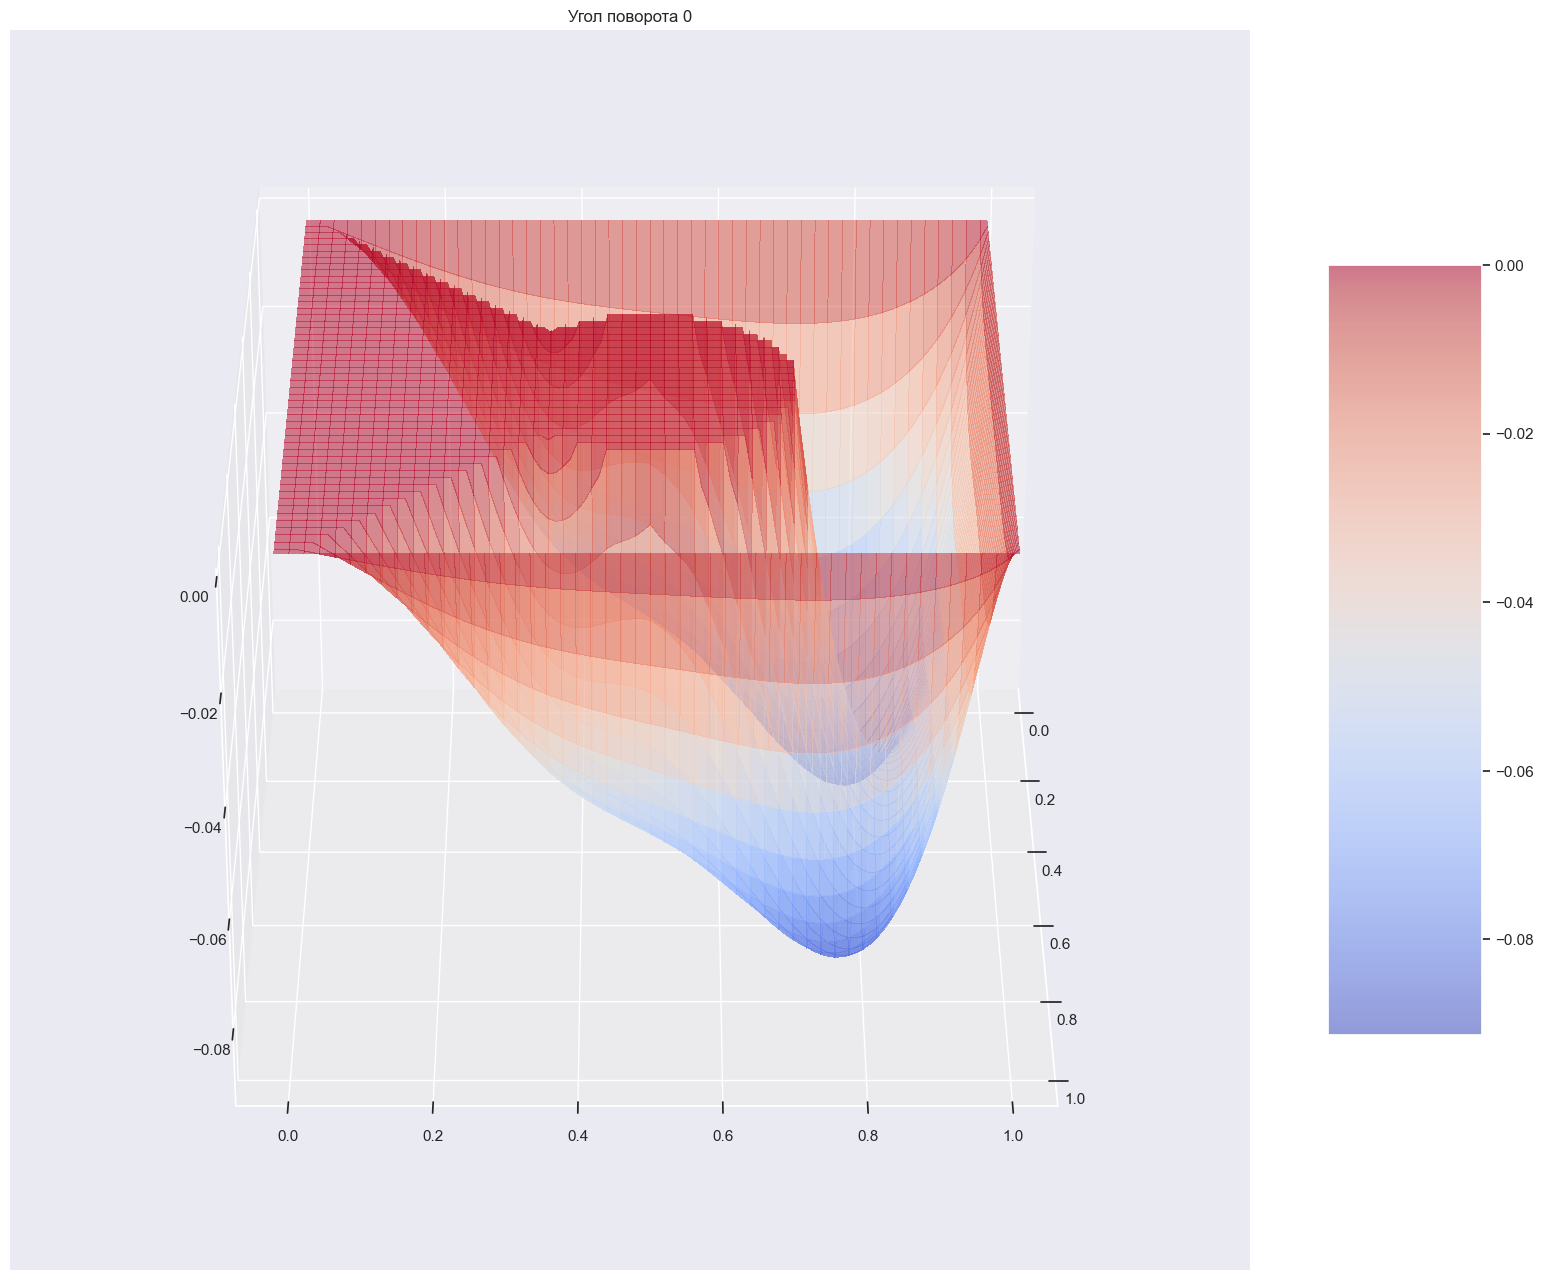

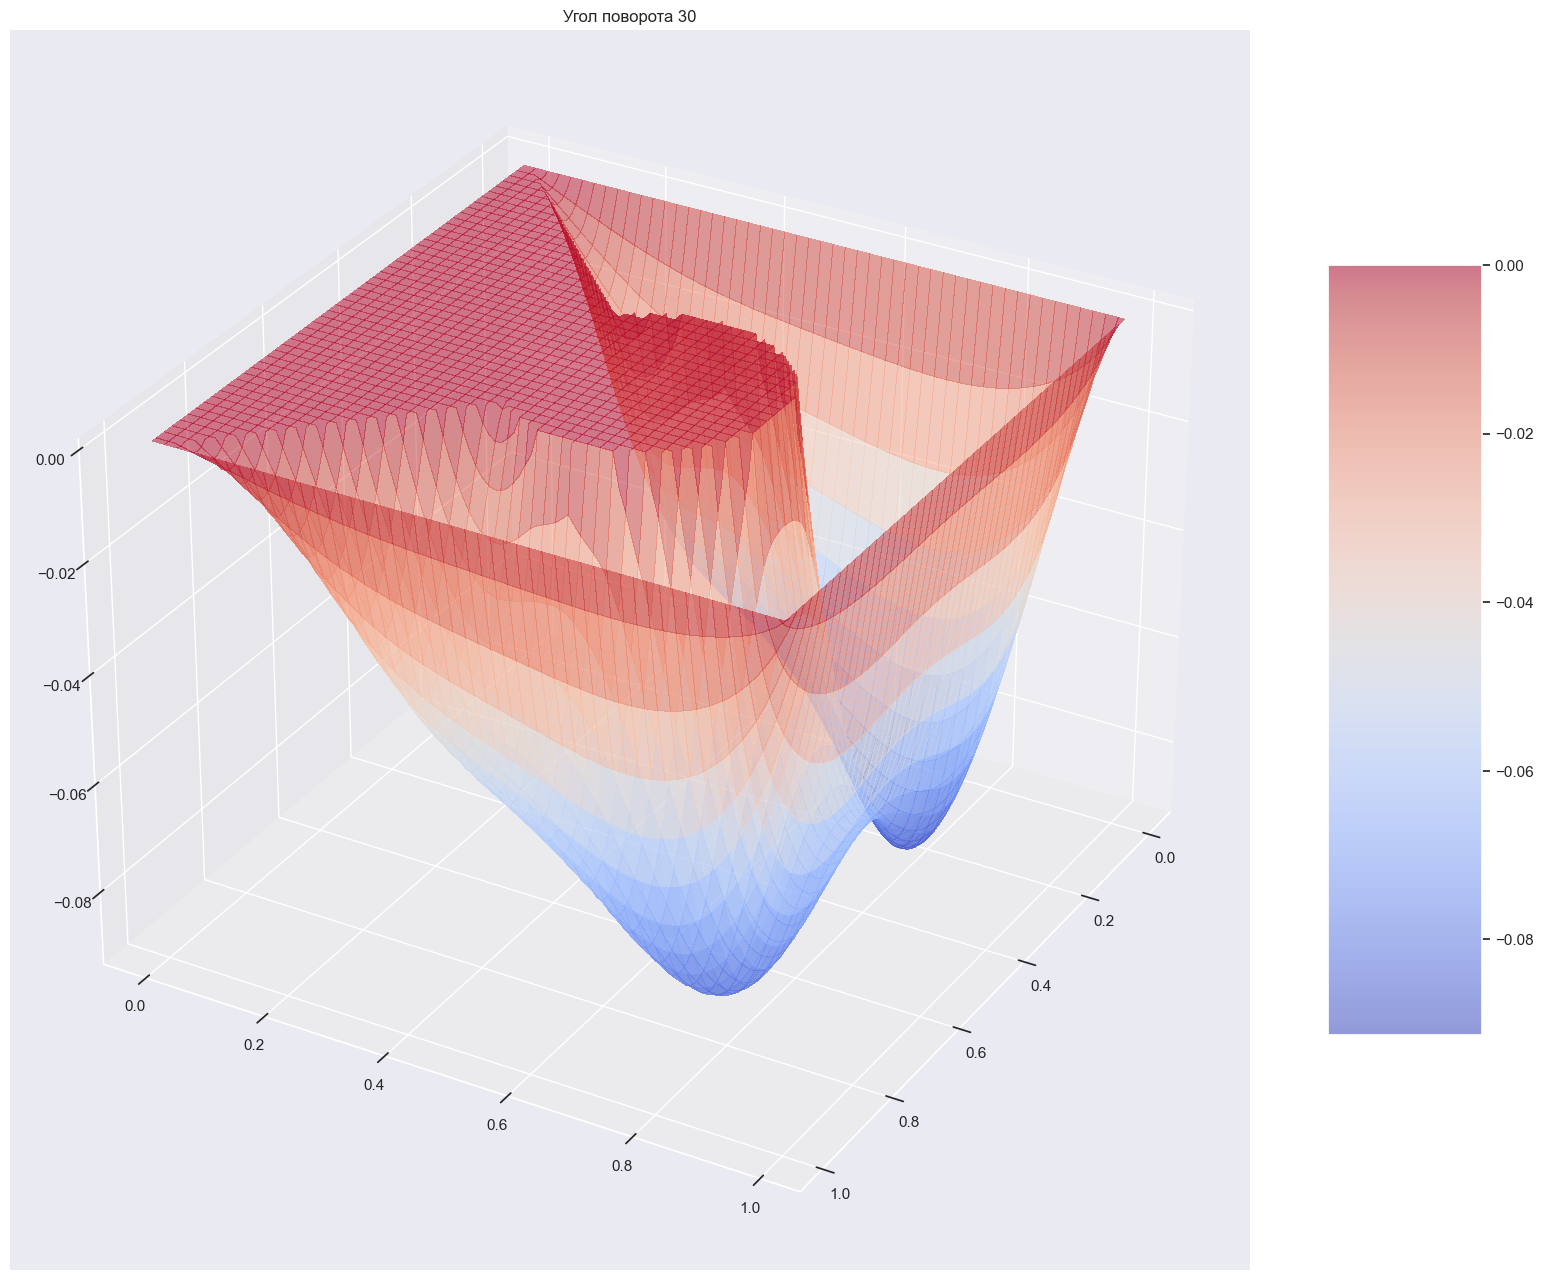

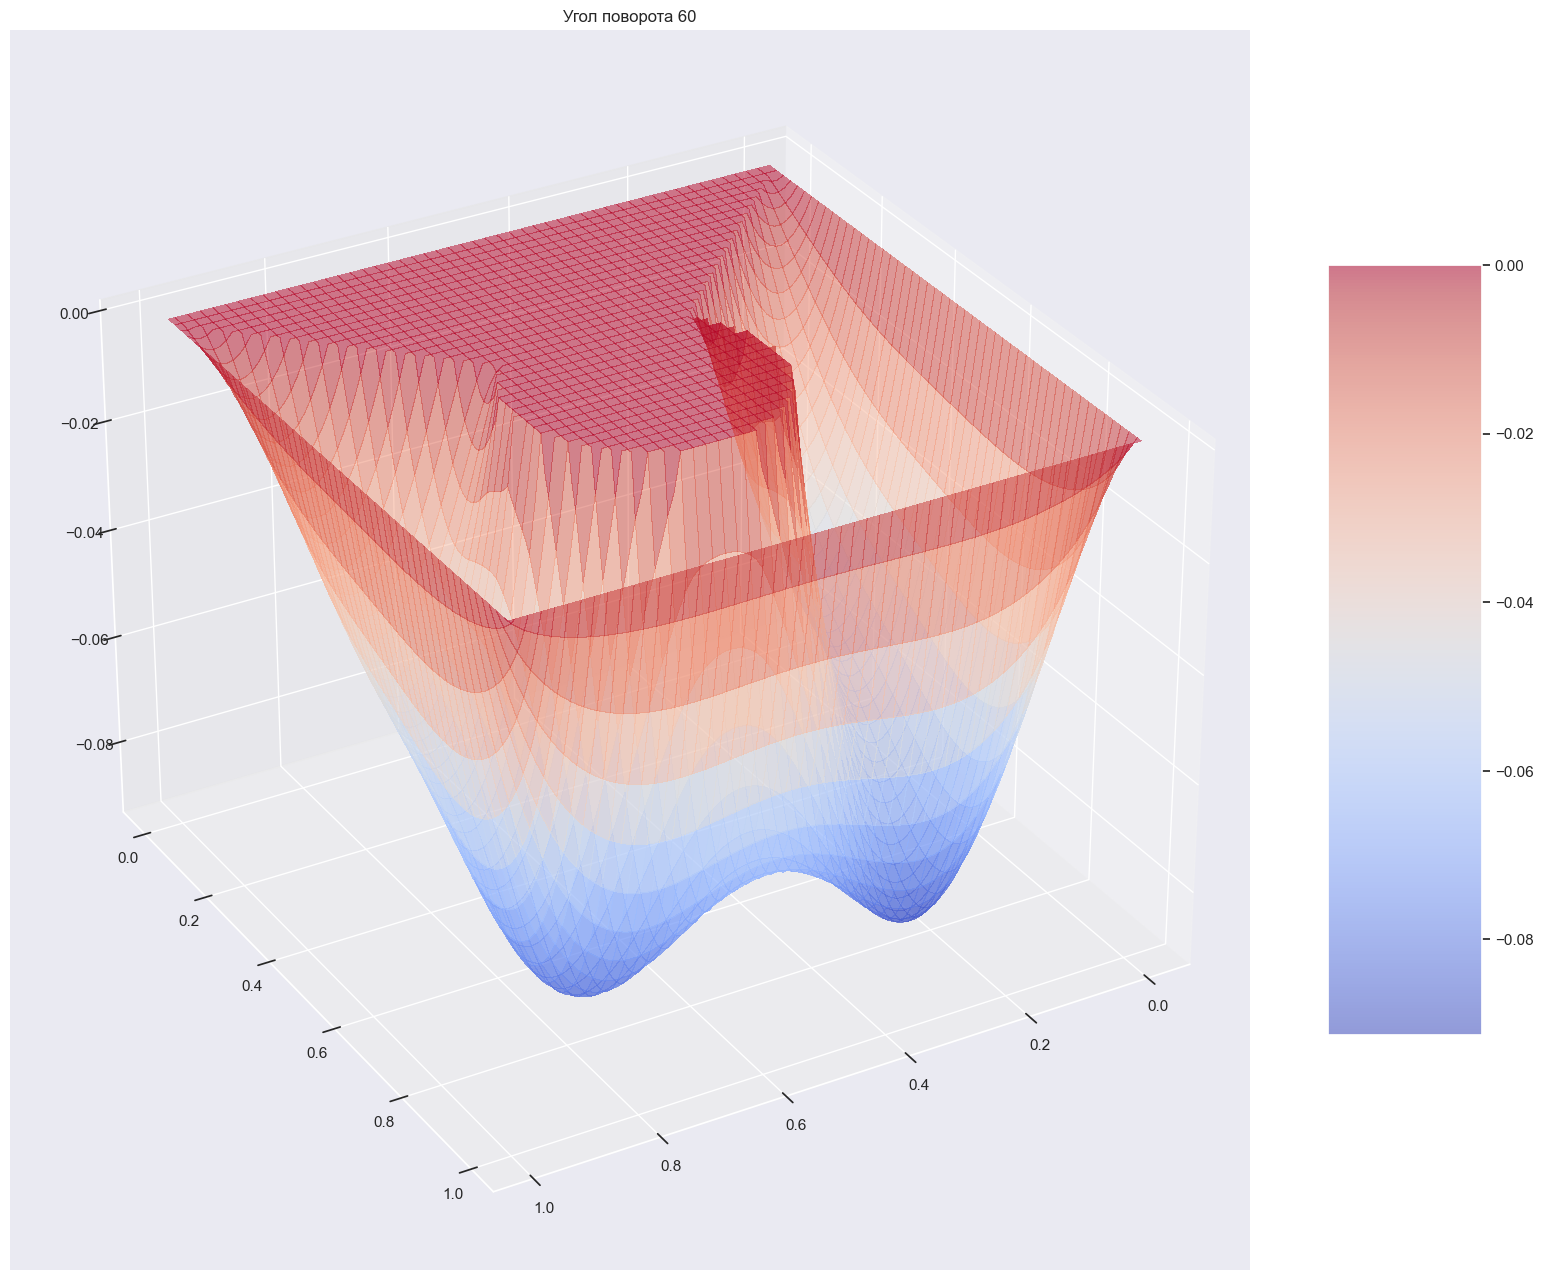

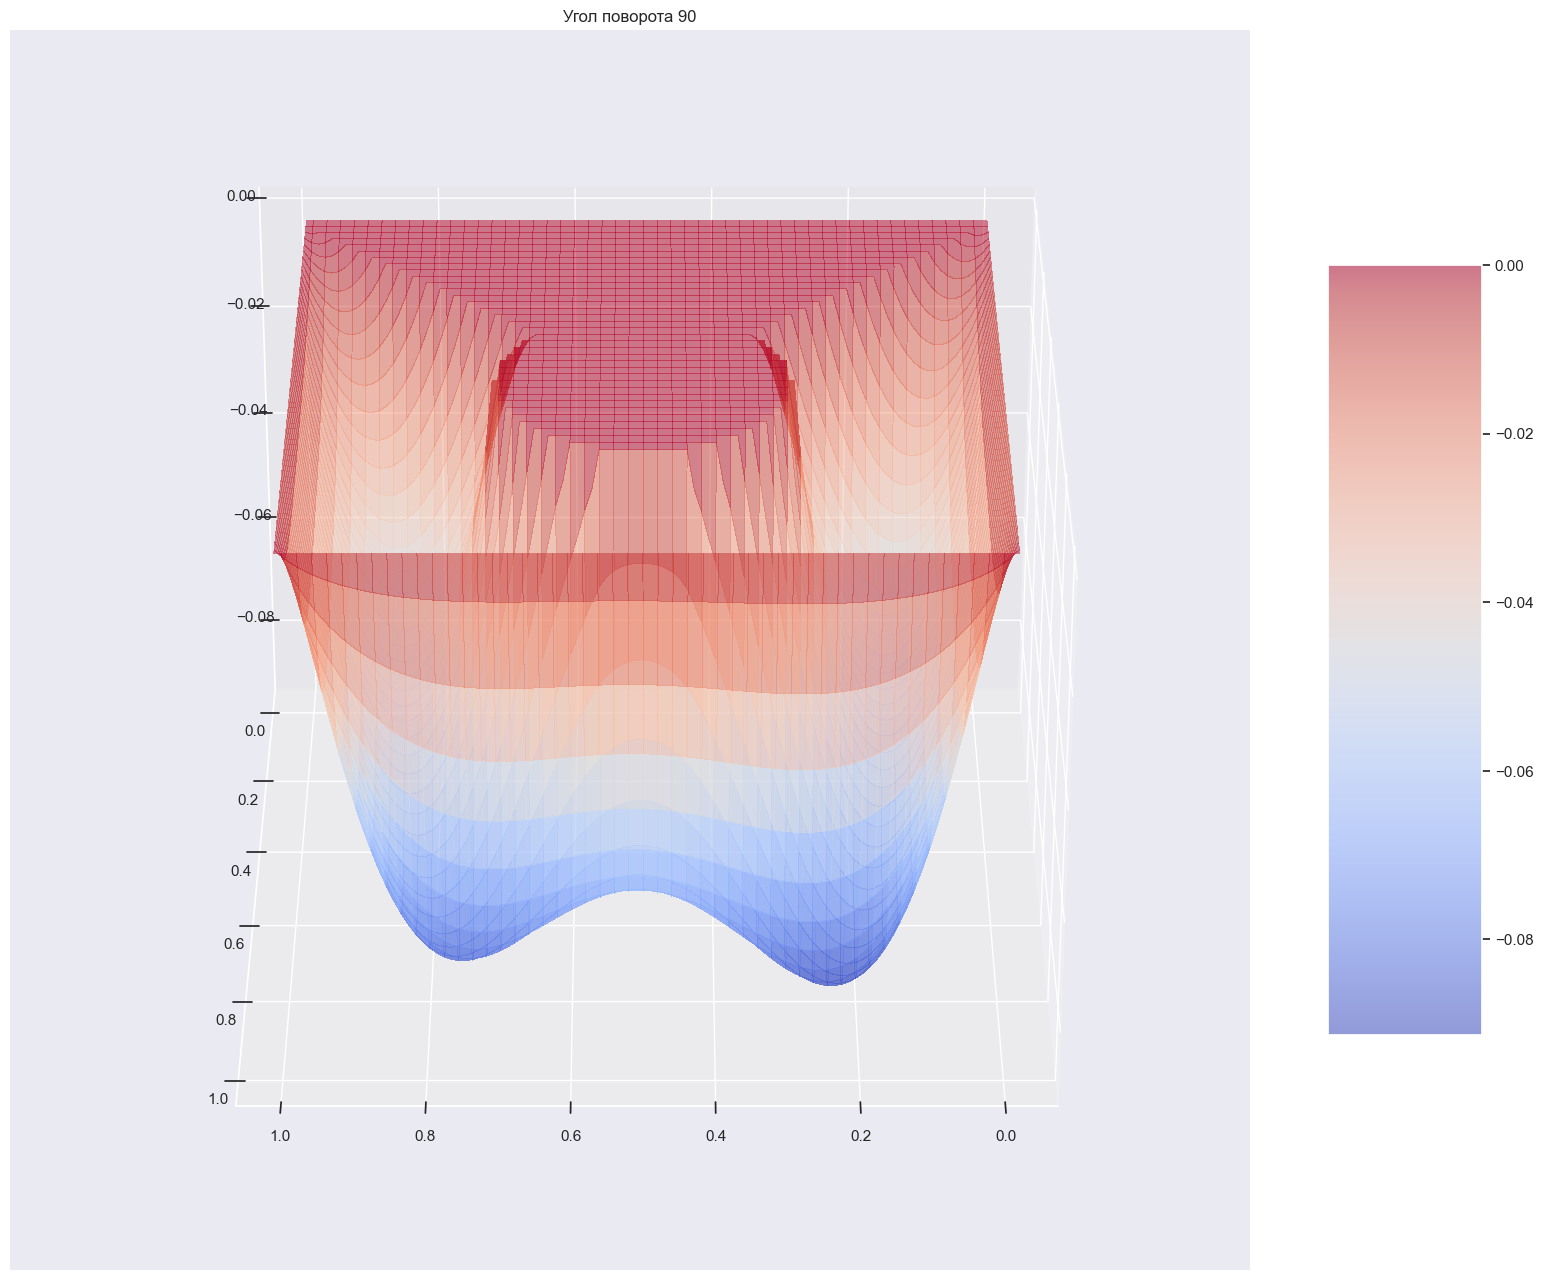

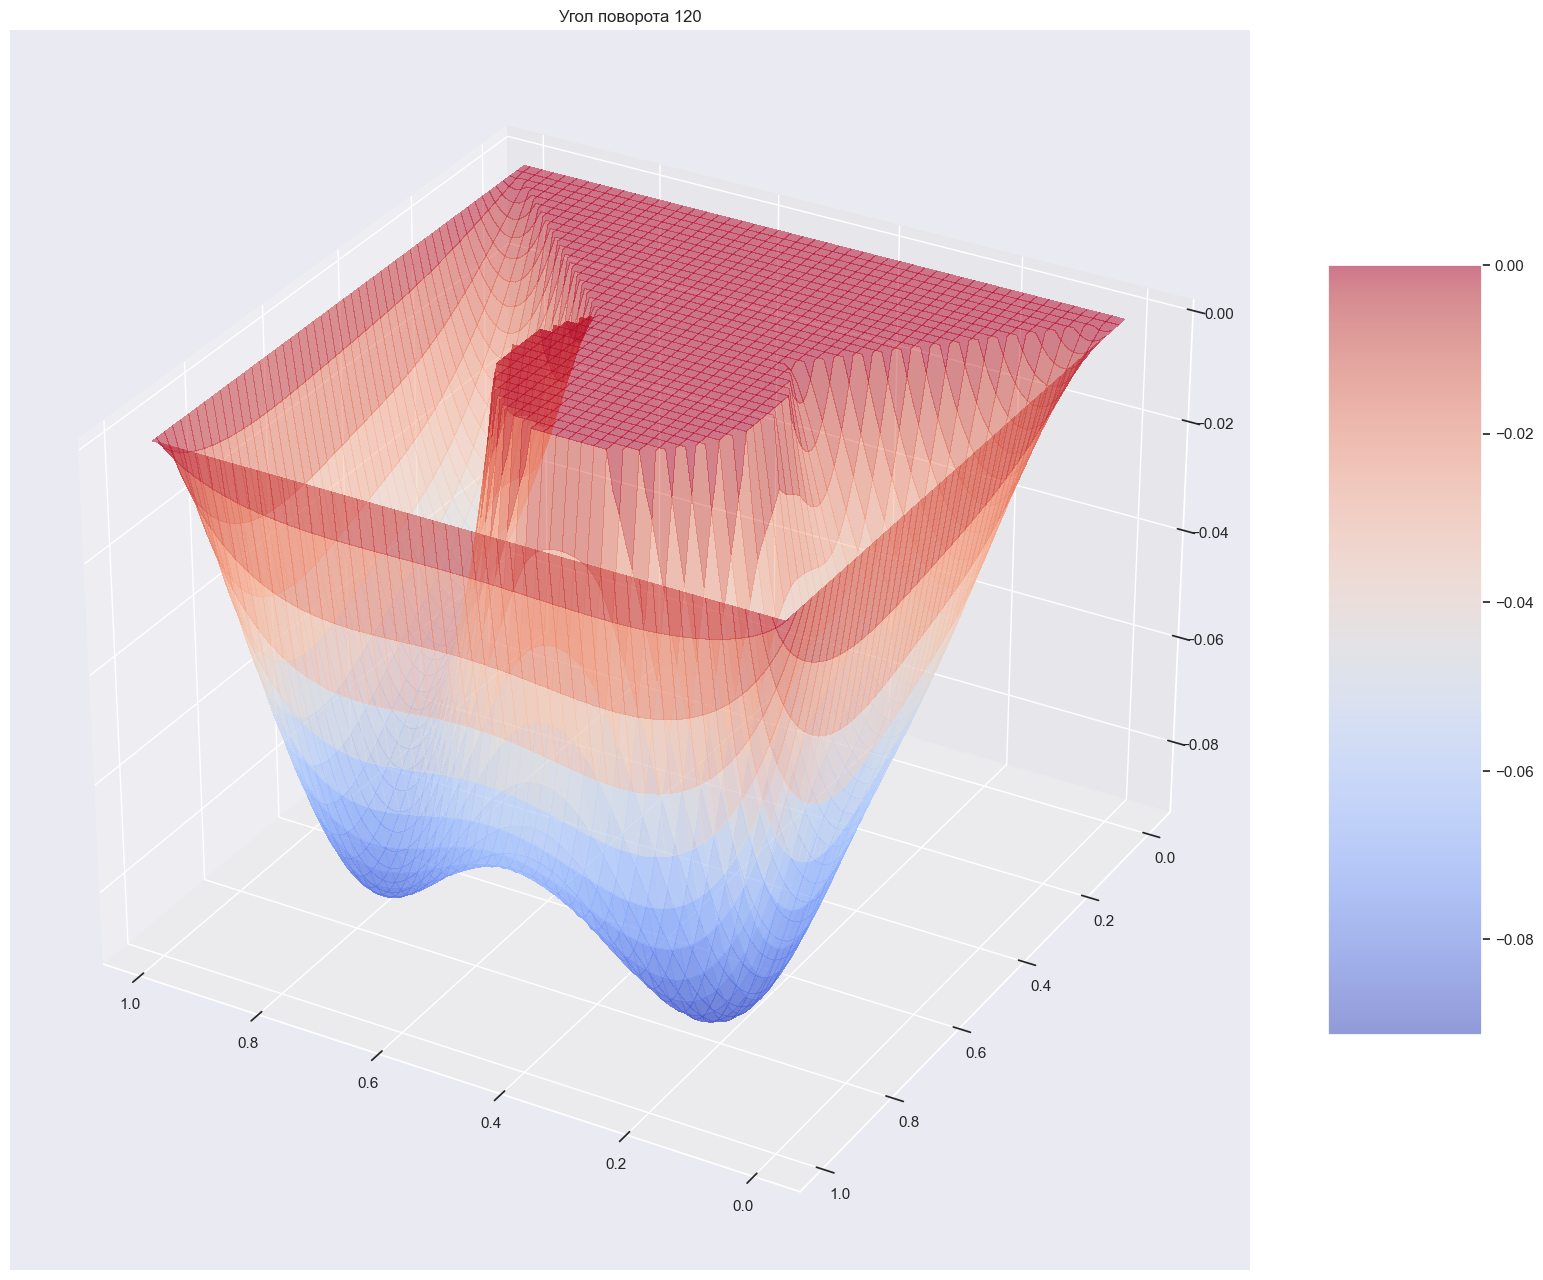

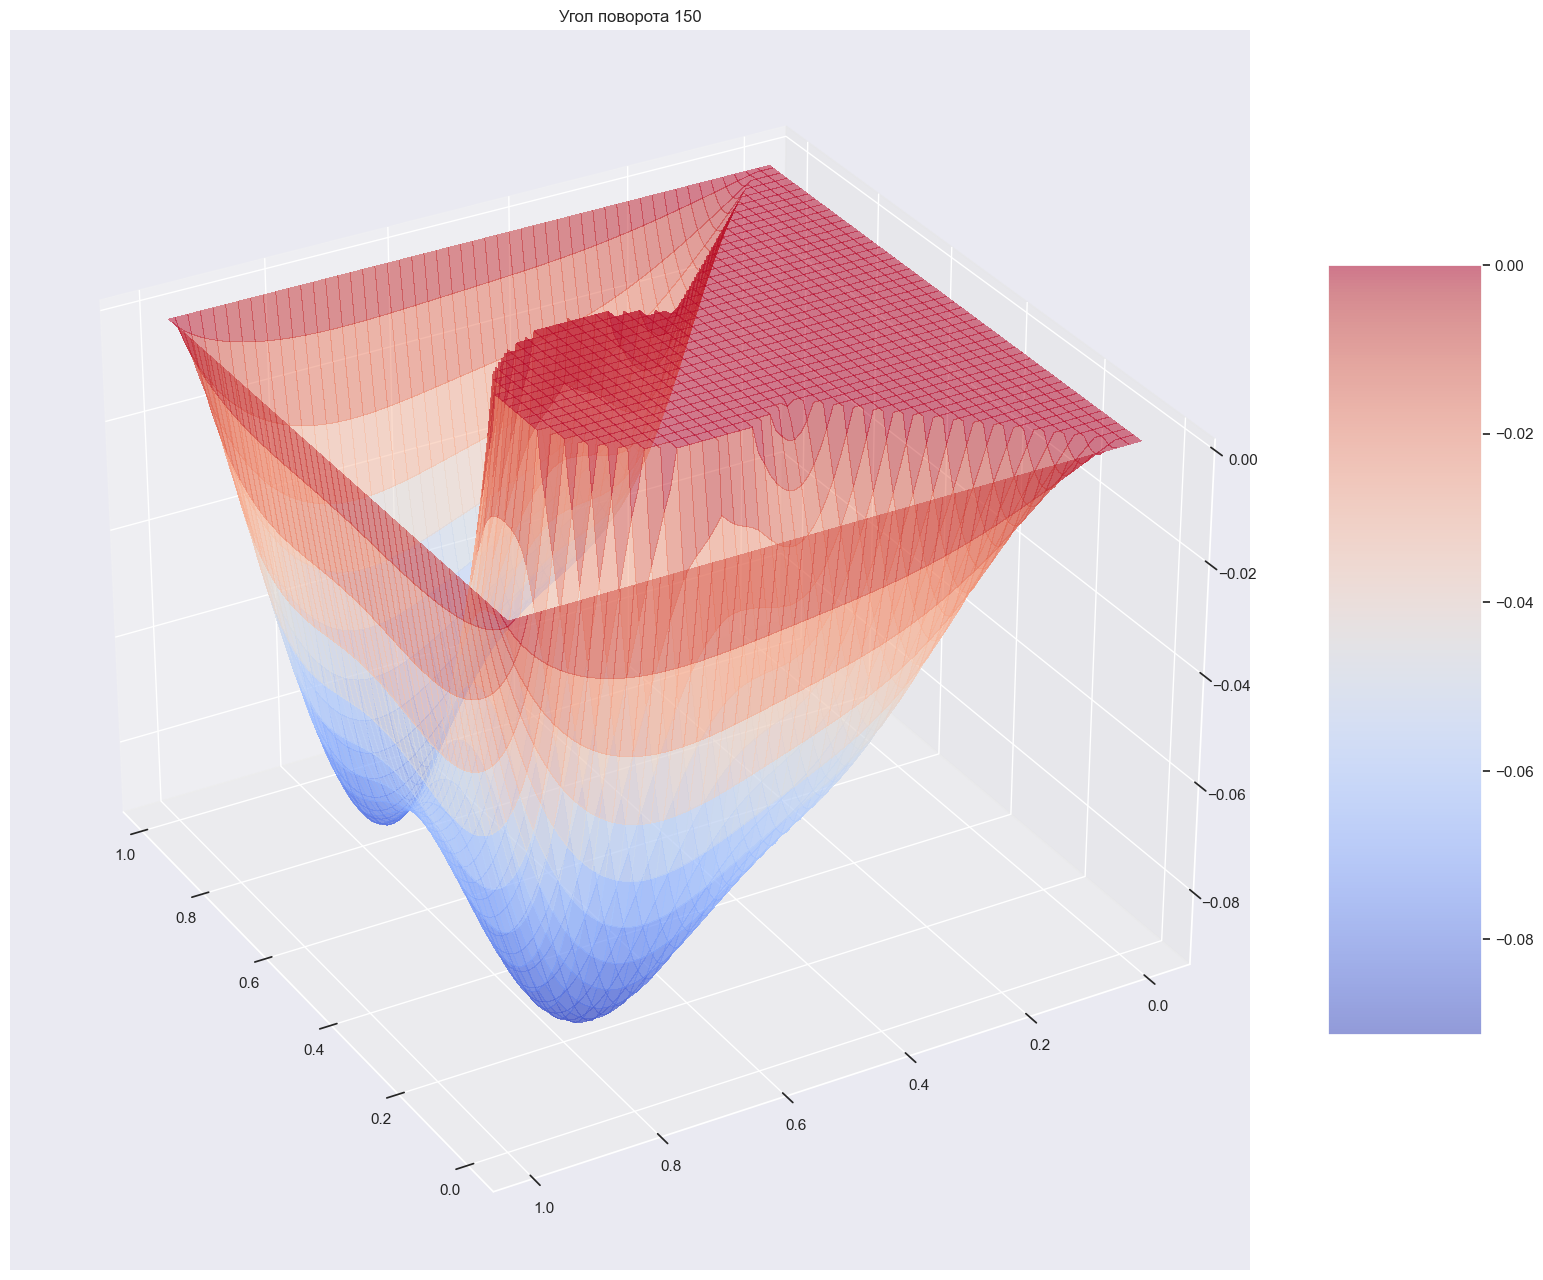

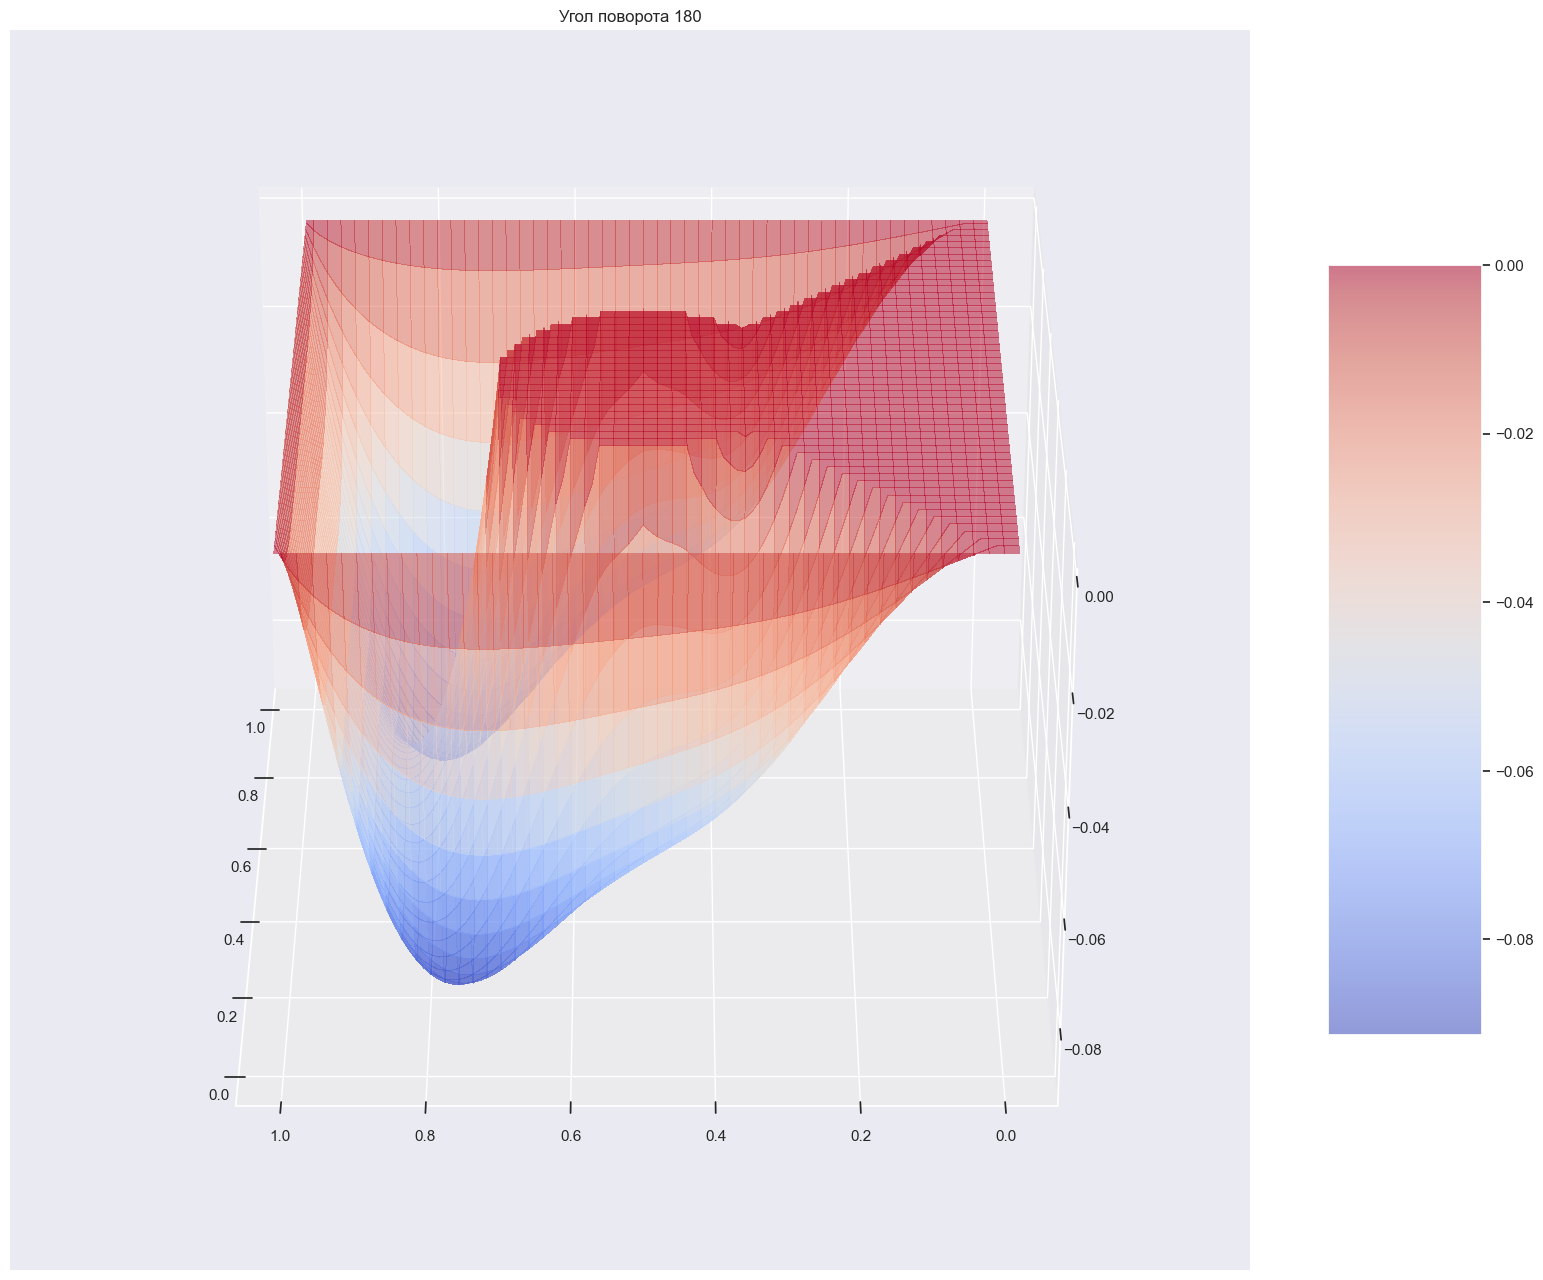

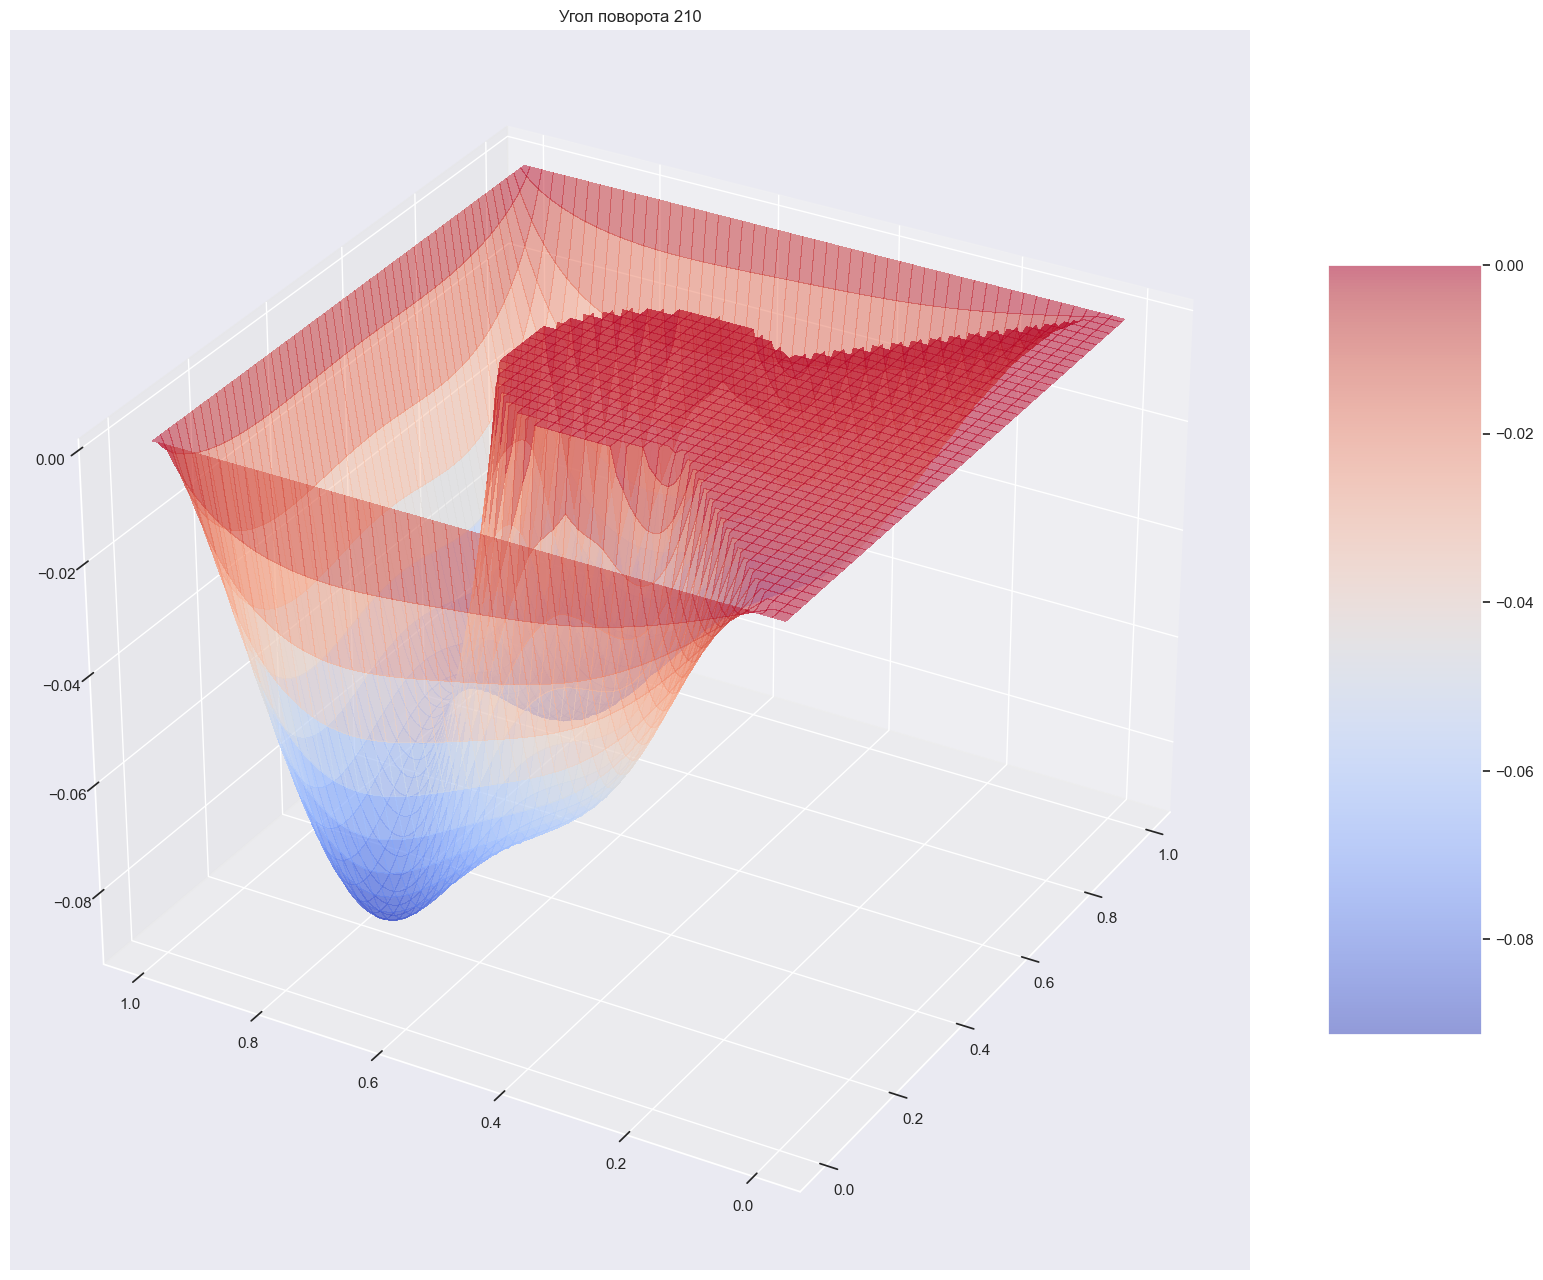

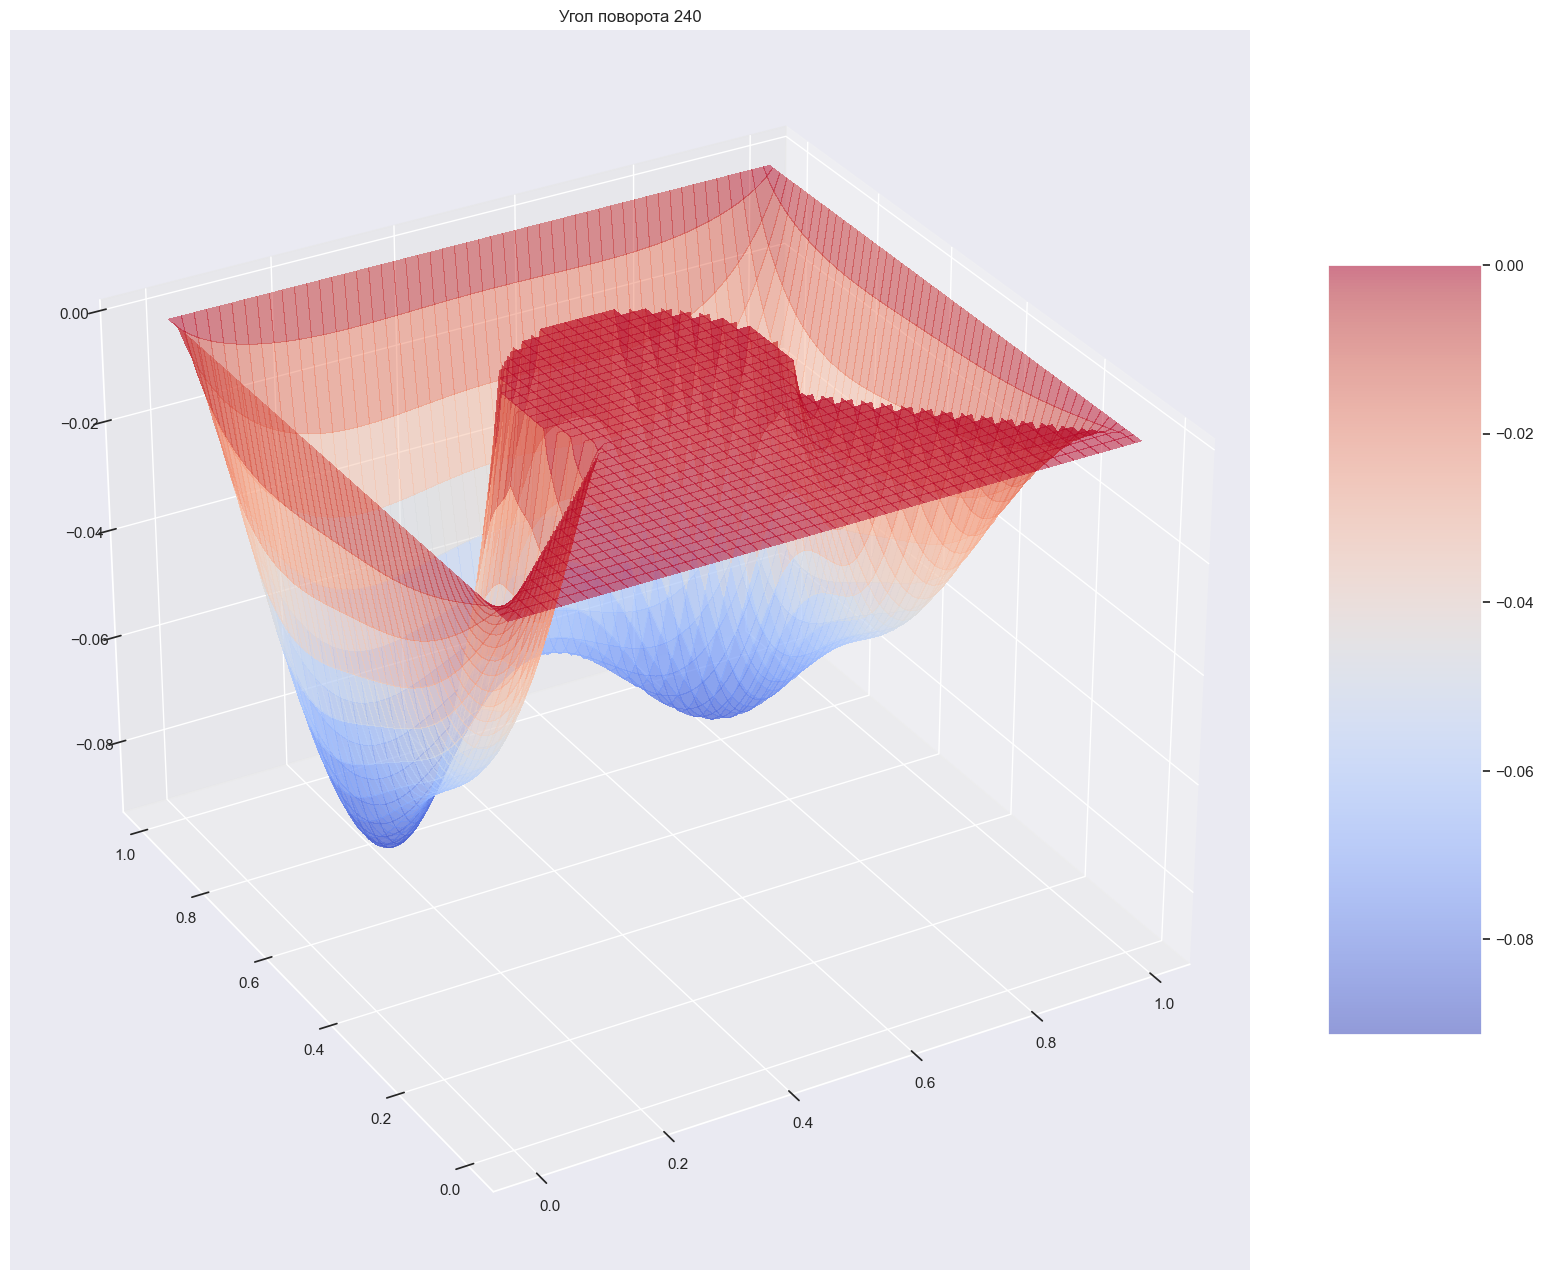

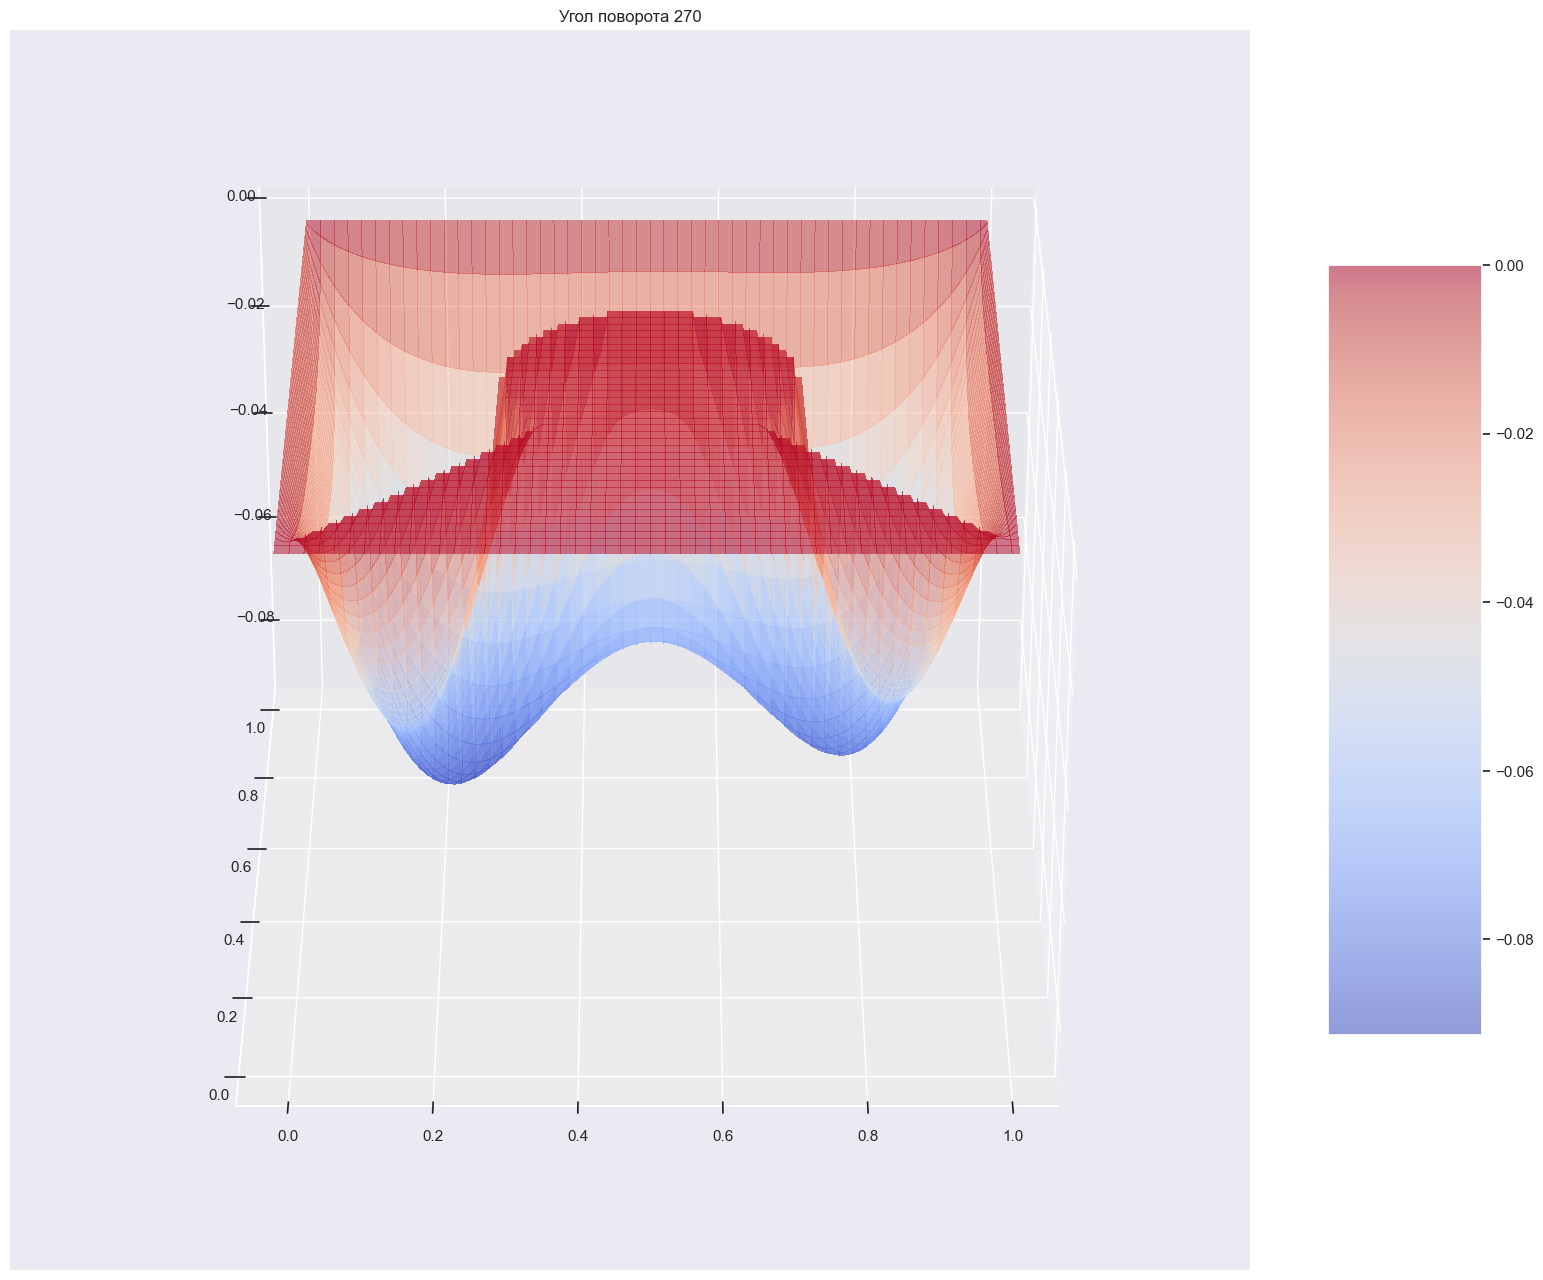

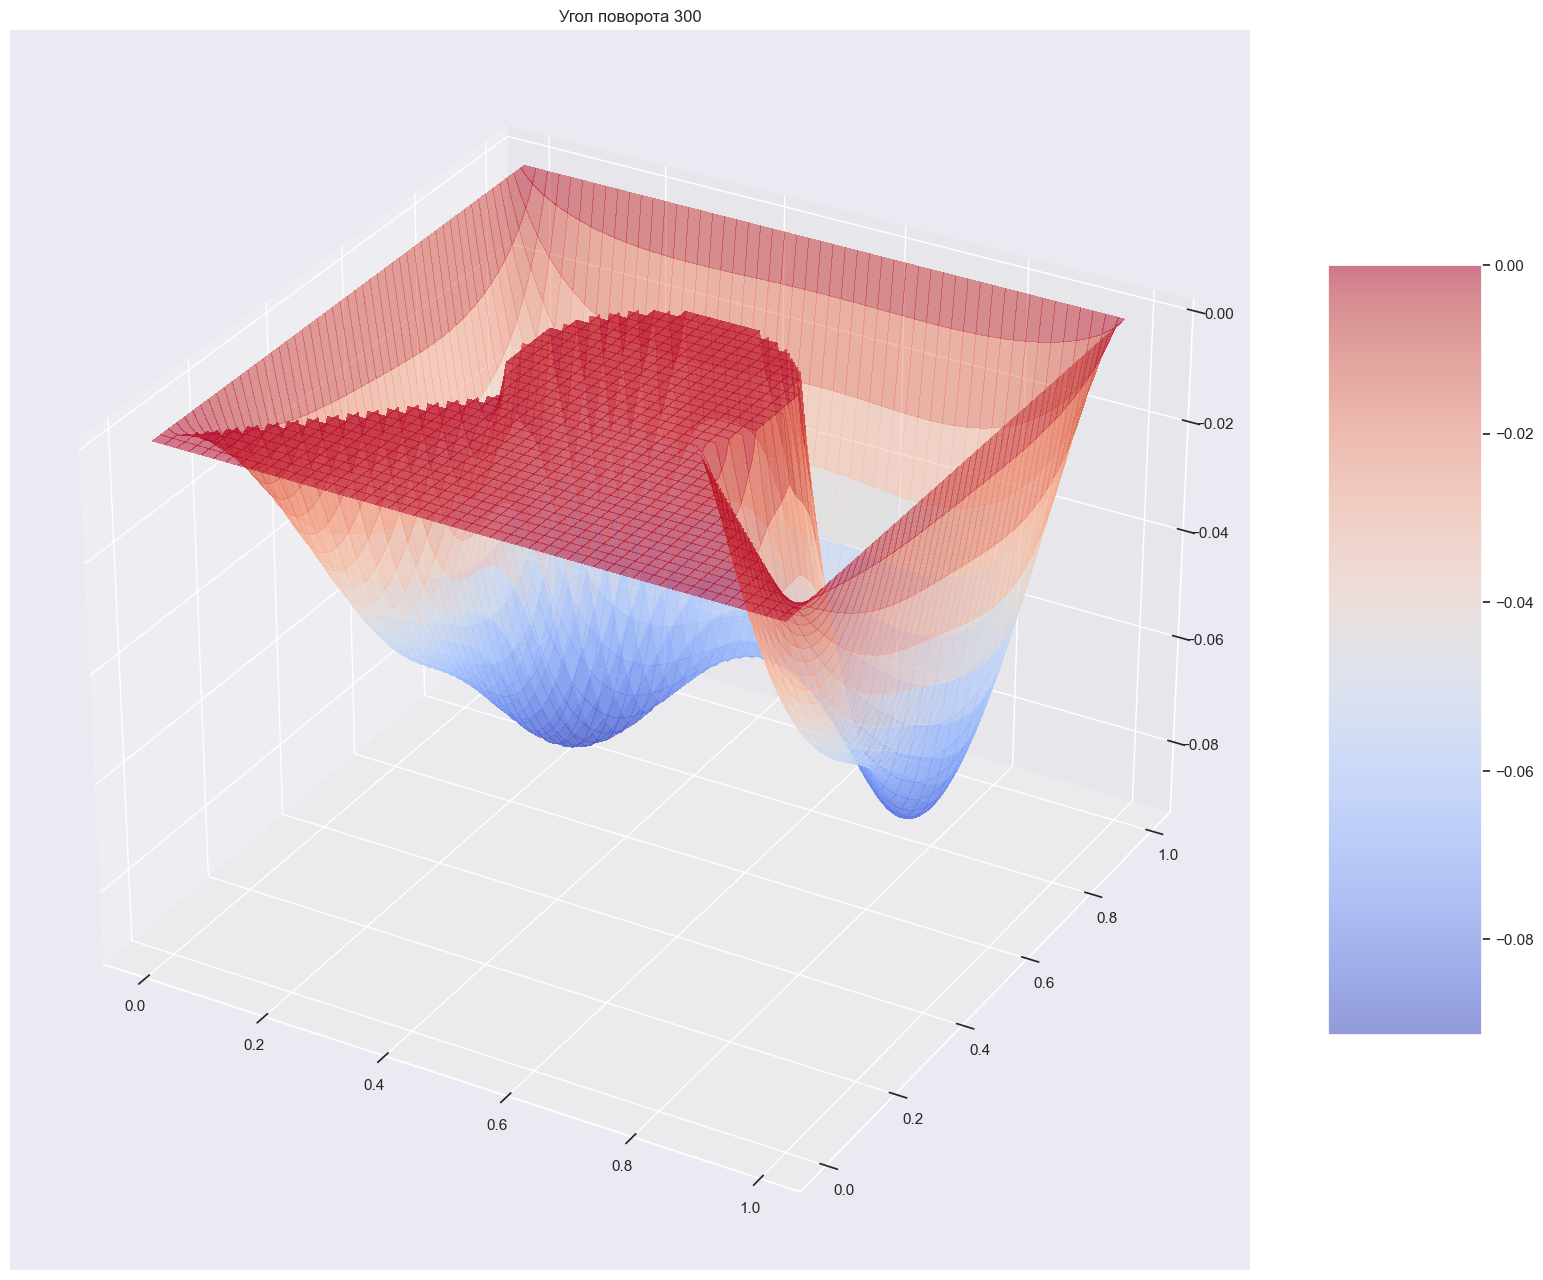

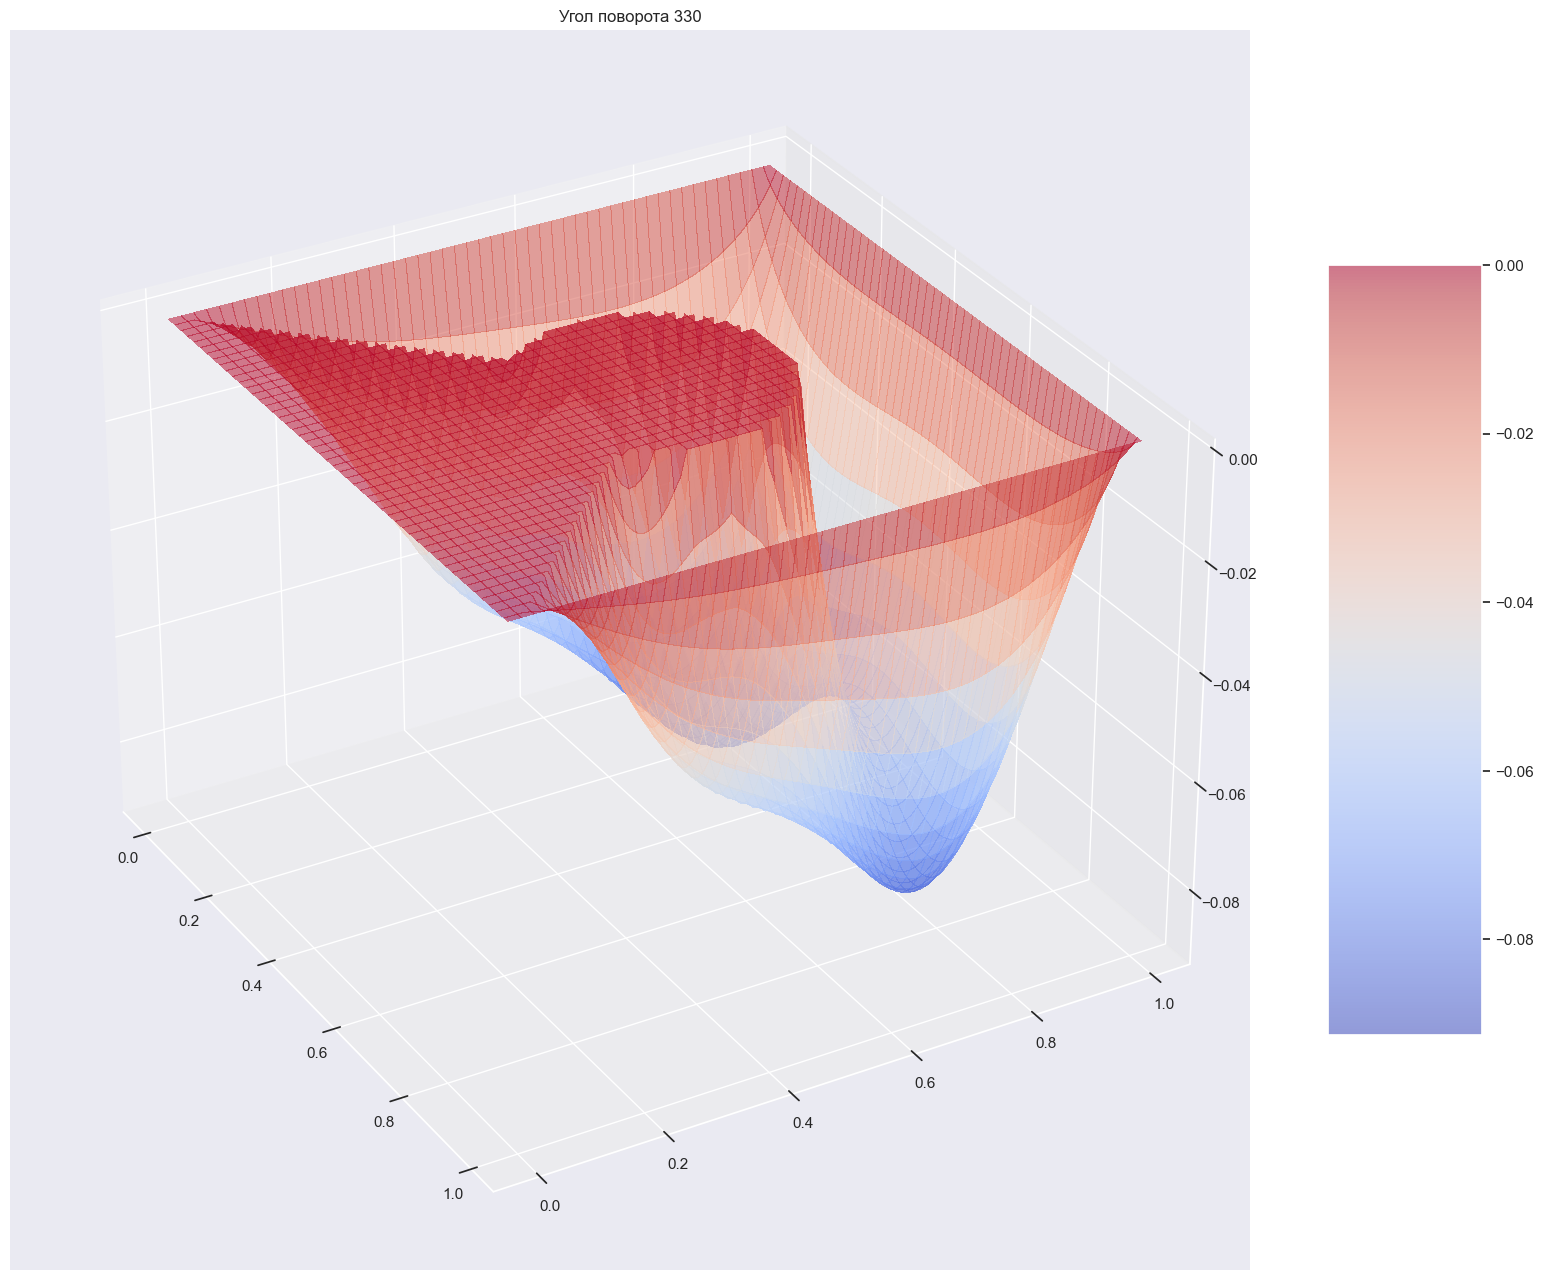

In [72]:
for i in range(12):
    fig = plt.figure(figsize=(20,20))
    ax = plt.axes(projection='3d')
    im = ax.plot_surface(X, Y, U_next, alpha=0.5, cmap=matplotlib.cm.coolwarm,
                           linewidth=0, antialiased=False)
    fig.colorbar(im, shrink=0.5, aspect=5)
    ax.set_title(f'Угол поворота {i*30}');
    ax.view_init(30, i*30)

Набросок

In [ ]:
#indx = np.where([mask[i] == 0])[1]
        #if indx.shape[0] != 0:
            #up, down:
        #    U_next[i][indx] = U_next[i][indx] + U_prev[i - 1][indx]
        #    U_next[i][indx] = U_next[i][indx] + U_prev[i + 1][indx]
            
            
            #left, right
        #    U_next[i][indx] = U_next[i][indx] + U_prev[i][indx - 1]
        #    U_next[i][indx] = U_next[i][indx] + U_prev[i][indx + 1]
            
            
            #linear
         #   U_next[i][indx] /= 4
         #  U_next[i][indx] -= (h**2 / 4)*F[i][indx]
